**RNN**

**数据集：**

采用前13天（13days/30s）没有空缺数据的数据集进行训练和检验

**预测目标：**

超短期预测（4h/15min）的风功率

**可调的参数：**
- 使用前多久的数据进行预测:400
- 数据集的特征: speed power
- 使用多少天的数据进行训练: 6 days
- LSTM units 数目: 100
- batch size: 72
- epoch: 100

In [8]:
n = 1
# 使用前400个点的 speed & power 预测接下来 4h(4h/15min) 的power
n_back = 400
n_out = 16
n_pre = n_out*15*2
n_feature = 2
# 使用前6天的数据进行训练
train_len = 6
# 神经网络参数
units = 100
rounds = 10
size = 72

# Preperation

In [2]:
from math import sqrt
import numpy as np
import pandas as pd

from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN

2023-01-09 20:28:12.010933: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-09 20:28:12.414623: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-09 20:28:12.414673: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-09 20:28:14.328884: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [3]:
dataset = pd.read_csv('../wind_preprocessed.csv', header=0, index_col=0).query('day<14')

In [4]:
data = dataset[['speed_moveavg', 'power_moveavg']].rename(columns={'power_moveavg':'power', 'speed_moveavg':'speed'})
print(data.head())

                       speed    power
date                                 
2015-10-01 00:00:00  0.39627  0.38065
2015-10-01 00:00:30  0.39592  0.36943
2015-10-01 00:01:00  0.39538  0.38529
2015-10-01 00:01:30  0.39579  0.38892
2015-10-01 00:02:00  0.39627  0.41220


# Training

In [5]:
values = data.values
values = values.astype('float32')

def series_to_supervised(data, n_in, n_out, colname, dropnan=True):
    n_vars = colname
    # n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (j, i)) for j in n_vars]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out, 15*2):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (j)) for j in n_vars]
        else:
            names += [('%s(t+%d)' % (j, i)) for j in n_vars]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# 构建成监督学习问题
reframed = series_to_supervised(values, n_back, n_pre, ['speed', 'power'])
# 丢弃我们不想预测的列
for i in range(0, n_pre, 15*2):
    if i == 0:
        colname = 'speed(t)'
    else:
        colname = f'speed(t+{i})'
    reframed.drop(colname, axis=1, inplace=True)
# print(reframed.head(5))

In [6]:
# 分割为训练集和测试集
values = reframed.values
n_train_hours = train_len*24*60*2
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# 分为输入输出
n_obs = n_back * n_feature
train_X, train_y = train[:, :n_obs], train[:, -n_out:]
test_X, test_y = test[:, :n_obs], test[:, -n_out:]
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)
# 重塑成3D格式 [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_back, n_feature))
test_X = test_X.reshape((test_X.shape[0], n_back, n_feature))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(17280, 800) (17280, 16)
(19310, 800) (19310, 16)
(17280, 400, 2) (17280, 16) (19310, 400, 2) (19310, 16)


In [9]:
# 设计网络
model = Sequential()
model.add(SimpleRNN(units, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(n_out))

# 拟合神经网络模型
model.compile(loss='mse', optimizer='adam')
history = model.fit(train_X, train_y, epochs=rounds, batch_size=size, validation_data=(test_X, test_y), verbose=1, shuffle=False)

Epoch 1/10
240/240 [==============================] - 99s 406ms/step - loss: 0.0443 - val_loss: 0.2499
Epoch 2/10
240/240 [==============================] - 90s 377ms/step - loss: 0.0670 - val_loss: 0.2470
Epoch 3/10
240/240 [==============================] - 79s 331ms/step - loss: 0.0553 - val_loss: 0.2898
Epoch 4/10
240/240 [==============================] - 84s 349ms/step - loss: 0.0549 - val_loss: 0.3222
Epoch 5/10
240/240 [==============================] - 81s 338ms/step - loss: 0.0544 - val_loss: 0.3454
Epoch 6/10
240/240 [==============================] - 78s 328ms/step - loss: 0.0535 - val_loss: 0.3620
Epoch 7/10
240/240 [==============================] - 95s 397ms/step - loss: 0.0528 - val_loss: 0.3695
Epoch 8/10
240/240 [==============================] - 111s 464ms/step - loss: 0.0513 - val_loss: 0.3690
Epoch 9/10
240/240 [==============================] - 85s 354ms/step - loss: 0.0494 - val_loss: 0.3759
Epoch 10/10
240/240 [==============================] - 99s 412ms/step - 

In [10]:
model.save_weights(f'rnn_{n}.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 100)               10300     
                                                                 
 dense_1 (Dense)             (None, 16)                1616      
                                                                 
Total params: 11,916
Trainable params: 11,916
Non-trainable params: 0
_________________________________________________________________


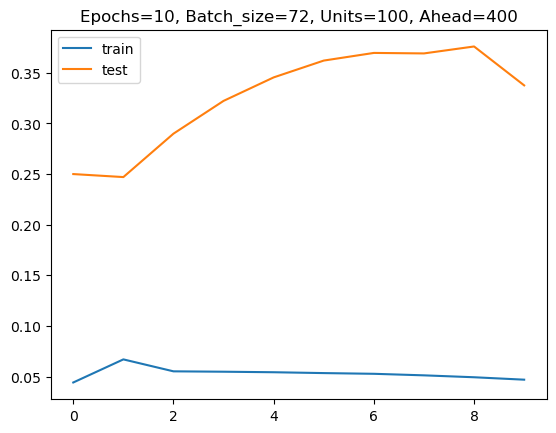

In [12]:
# 绘制历史数据
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title(f'Epochs={rounds}, Batch_size={size}, Units={units}, Ahead=400')
plt.savefig(f'{n}.png')
plt.legend()
plt.show()